# Supermarket Customer Segmentation

This notebooks looks into the implementation of a end-to-end Data Science framework in an attempt to obtain insights about the customer segmentation for a particular supermarket.

The approach is as follows:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem definition

You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

You own the mall and want to understand the customers, like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

## 2. Data 

The data used in this project can be found [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python). 


## 4. Features

### 4.1. Features description

Let us describe the features of the data we have:

* **CustomerID:** Unique identifier of a customer.
* **Gender:** Gender fof the customer (Male or Female).
* **Annual Income (k$):** Annual income of the customer in thousands of dollars.
* **Spending Score (1-100):** Customer score based on defined parameters sucha as customer behavior or purchasing data.



### 4.2. Importing our tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D


plt.style.use("ggplot")


In [2]:
data = pd.read_csv("data\Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 4.3. Exploring our data

Let's see how many samples we have

In [3]:
len(data)

200

Do we have any missing data?

In [4]:
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Nope

Now let's analyze the features we have. At a glance, Customer ID seems not to bring any useful information regarding customer segmentation, so we will discard it.

In [5]:
data.drop("CustomerID", axis=1, inplace=True)

We will also change the name of the features in our DataFrame to make it easier to handle

In [6]:
data["Annual Income"] = data["Annual Income (k$)"]
data["Spending Score"] = data["Spending Score (1-100)"]

data.drop(["Annual Income (k$)", "Spending Score (1-100)"], axis=1, inplace=True)
data.head()

,Gender,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### 4.4. Exploratory Data Analysis

Let's get deeper into our data. We will check the distribution of each of the features and how they relate to each other.

#### 4.4.1. Univariate analysis

We only have one categorical feature (`Gender`), the other are numerical

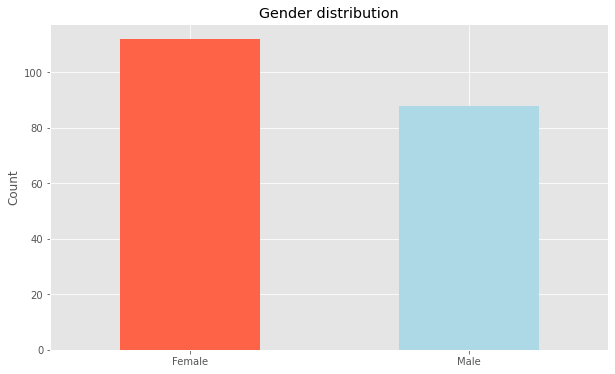

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
data["Gender"].value_counts().plot(kind="bar",
                                   color = ["tomato", "lightblue"],
                                   ax=ax)
ax.set(title="Gender distribution",
       ylabel="Count")                                
plt.xticks(rotation=0);

We see a slight female majority among the customers in our data.

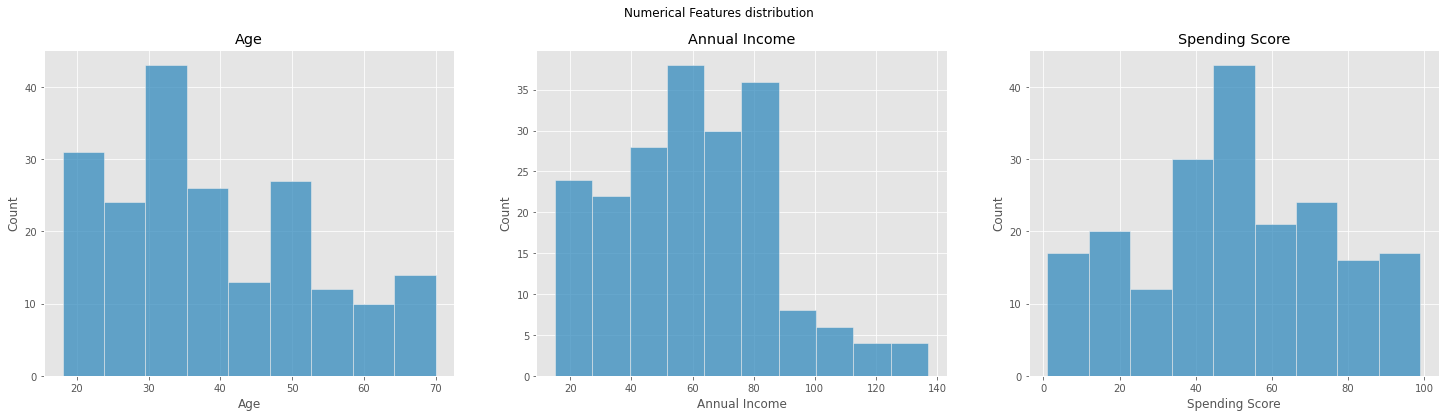

In [8]:
fig = plt.figure(figsize=(25,6))
i = 1
for feature in data.columns:
    if feature != "Gender":
        sub = fig.add_subplot(1, 3, i)
        g = sns.histplot(data[feature], ax=sub)
        sub.set(title = feature)
        i += 1
fig.suptitle("Numerical Features distribution");

From the charts above one can see interesting things about the data:
* Most of the customers are between ages 20 and 60, with higher concentration in younger customers. (right-skewed dirtribution)
* Regarding annual income, 75% of the customers are bellow 78K USD.
* The spending score distribution is almost symmetric. There is no significant skewness. High concentration in a score around 50.




#### 4.4.2. Multivariate analysis

Now let's analyze the raltionship between features

In [9]:
data_enc = data.replace({"Gender": {"Female": 0, "Male": 1}})

We plot some boxplots for the numerical features vs the gender, to see if these numerical features show a different behavior depending on gender. (Female = 0, Male = 1)

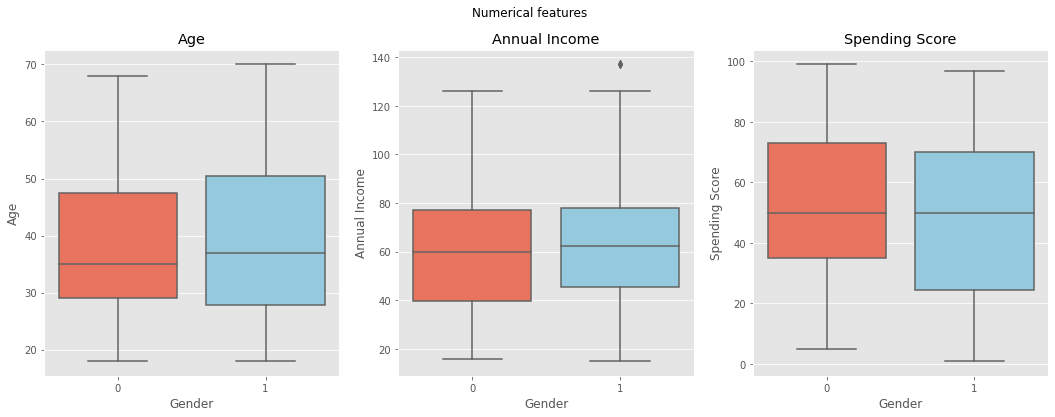

In [10]:
fig2 = plt.figure(figsize=(18,6))

numerical_columns = [col for col in data.columns if col != "Gender"]

for i in range(len(numerical_columns)):
    column = numerical_columns[i]
    sub = fig2.add_subplot(1, 3, i + 1)
    sns.boxplot(x = "Gender", y = column, data = data_enc, palette={0: "tomato", 1: "skyblue"}, ax=sub)
    sub.set_title(column)
fig2.suptitle("Numerical features");

The boxplots are very similar for both genders, and although the next affirmations may not be conclussive it is interesting to notice some patterns:
* Male customers seem to be have more older people than their female peers.
* Female customers tend to have a slightly higher spending score than male customers.

Let's check the correlation between the features:

<AxesSubplot:>

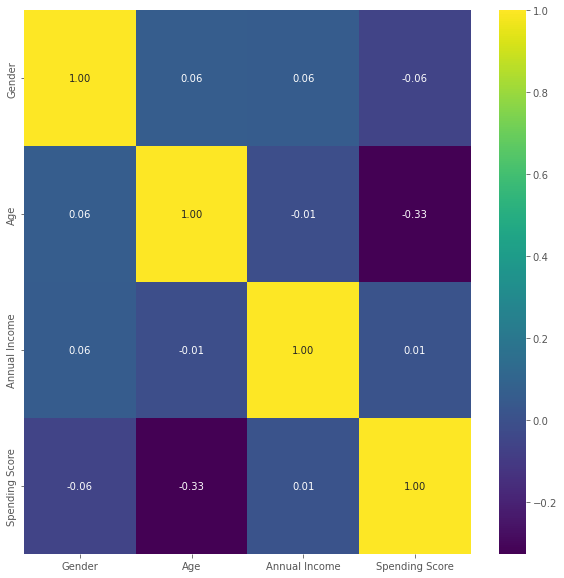

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
correlation = data_enc.corr()
sns.heatmap(correlation, cmap="viridis", annot=True, fmt=".2f")

The matrix shows no significant correlation between the features. Although it seems that there is a negative correlation between age and spending score, which could be interpreted as young customers having better spending scores than old customers.

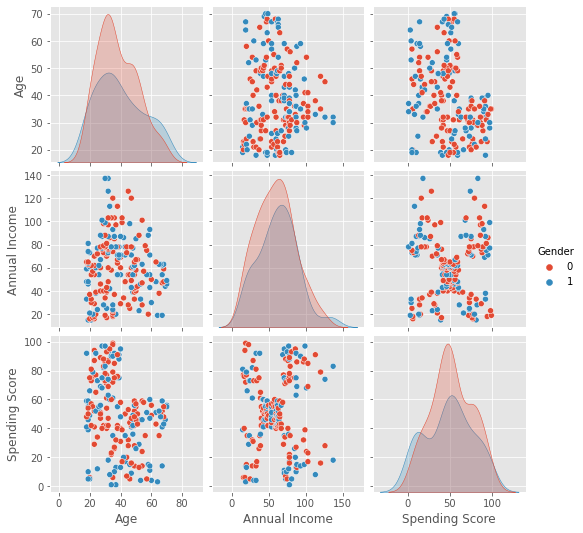

In [12]:
sns.pairplot(data = data_enc, hue="Gender")

The above plot allows us to visualize better the relationship between features. The charts in the diagonal display very interesting information about the relationship between the numerical features and gender, it is easier to understand than a boxplot (at least for me). For instance: 
* For age, the females seem to be concentrated in a 20 to 50 years-old range; whereas for men the distribution is more spread. Interesting enough is to notice how there are more males than females for customers older than 60 years old.
* There is a higher concentration of women in a low-annual-income range relative to men's distribution.
* Regarding Spending Score, the male-customers distribution seems to be bimodal with peaks at about 15 and 50, which would indicate that there is a concentration of male customers with a relatively low spending score. For females, the distribution is fairly symmetric.

It is important to claim that the charts in the diagonal are very sensitive to outliers. A good practice would be to deal with the outliers before ploting these kind of charts.

The charts that are not in the diagonal show the relationships between two variables, actually three if we account for the coloring of the points based on the gender.
Neither of these charts show a significant correlation between the features, but we are able to see some interesting clusters of data points for the Annual Income vs Spending Score charts.

This takes us to next step

## 5. Applying a clustering algorithm

Now we will segmentate the customers based on gender, age, annual income and spending score. For this we will use a clustering algorithm called K-Means. We have already seen that for some features there are already some clusters, so we will see if K-Means will be able to identify them as well.

### 5.1 K-Means

We do not know the number of clusters beforehand. What we are going to do is to try several values for k (k=number of clusters), plot the inertia or WCSS (within-cluster sum-of-squares) and apply the "elbow method", to choose the right number of clusters. The "elbow method" states that the optimal value of k is that for which the WCSS vs k plot starts looking parallel to the x-axis or the plot starts getting a linear behavior.

Take WCSS as some kind of within-cluster-entropy, a well defined and concentrated cluster will have a low value of WCSS, whereas a more noisy and spread cluster will have a high value of WCSS.


In [13]:
def kmeans_get_best_k(data):
    """
    Plots the WCSS for a KMeans model given 
    k number of clusters

    Params:
    data: Dataframe with data in numeric format

    Returns:
    inertia_values: List of the WCSS for every value of k 
    """
    k_values = np.arange(2,13)
    inertia_values = []
    for k in k_values:
        inertia_model = []
        for _ in range(5):
            kmeans_model = KMeans(n_clusters=k)
            kmeans_model.fit(data)
            inertia_model.append(kmeans_model.inertia_)
        inertia_values.append(np.mean(inertia_model))

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(k_values, inertia_values)
    ax.set(title="WCSS vs Number of clusters",
        ylabel="WCSS",
        xlabel="Number of clusters")                                
    plt.xticks(k_values)
    plt.show()
    return inertia_values

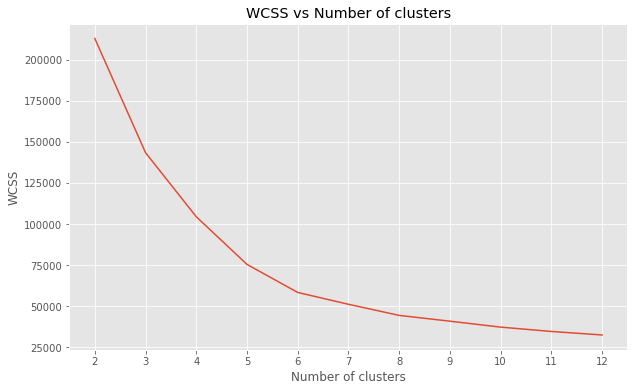

In [14]:
inertia_values = kmeans_get_best_k(data_enc)

Based on the elbow method, looks like 6 is a good value for k. 

Now because K-Means algorithm is based on euclidean distance it would be wise to scale our data. We will fit KMeans with 4 datasets: non-scaled data, min-max data, standardized data and data with robust scaler applied. Then we will visualize how well separated are the clusters obtained through K-Means.

Our data set has 4 features, so visualizing the data points with all dimensions as axis in a plane impossible. We will apply a dimensionality reduction technique called PCA to get the projection of our dataset onto 2 axis that maximize the variance. This will allow us to visualize our data points in a 2D-plane.

In [15]:
def scale_data(data):
    """
    Returns a dict with the non-scaled data, 
    minmax-scaled data, standardized data 
    and robust data

    Params: 
    data - Dataframe with numerical data

    Returns:
    Dictionary with the scalings of the data
    """
    minmax_scaler = MinMaxScaler()
    data_minmax = minmax_scaler.fit_transform(data)

    standard_scaler = StandardScaler()
    data_standard = standard_scaler.fit_transform(data)

    robust_scaler = RobustScaler()
    data_robust = robust_scaler.fit_transform(data)

    data_dict = {"Non-scaled data": data,
                 "Min-max data": data_minmax,
                 "Standardized data": data_standard,
                 "Robust data": data_robust}
    return data_dict

In [16]:
def find_clusters(data, n_clusters):
    """
    Generate clusters through KMeans for 
    non-scaled data, minmax-scaled data,
    standardized data, robust data

    Parameters:
    data: Non-scaled Dataframe with numerical values 
    n_clusters: Number of clusters to find

    Returns 
    cluster_data_dict : Dictionary with the data, the cluster label for each 
    sample and the center of the clusters, for each of the type of data scalings
    """
    data_dict = scale_data(data)

    cluster_data_dict = {}

    for data_name, data_scaled in data_dict.items():
        
        cluster_data_dict[data_name] = {}

        kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_model.fit(data_scaled)

        cluster_assignation = kmeans_model.predict(data_scaled)
        
        cluster_data_dict[data_name] = {"data": data_scaled,
                                        "cluster_assignation": cluster_assignation,
                                        "clusters_centers": kmeans_model.cluster_centers_}        
    return cluster_data_dict

In [17]:
def visualize_clustering(cluster_data_dict):
    """
       Plots the clusters and their centroids for 
       all the types of data scalings

       Params:
       cluster_data_dict: Dictionary with clustering info 
       about the diferently scale datasets 
    """
    colors = ["tab:blue", "tab:orange", "tab:green", 
              "tab:red", "tab:purple", "tab:olive",
              "tab:brown", "tab:pink", "tab:cyan"]

    fig = plt.figure(figsize=(15,10))
    i = 1

    for data_name, data_dict in cluster_data_dict.items():
        
        pca_ = PCA(n_components=2)
        data_pca = pca_.fit_transform(data_dict["data"]) 
        
        cluster_centers_pca = pca_.transform(data_dict["clusters_centers"])

        sub = fig.add_subplot(2, 2, i)

        for n_cluster in np.unique(data_dict["cluster_assignation"]):
                data_cluster = data_pca[data_dict["cluster_assignation"] == n_cluster]
                sub.scatter(data_cluster[:,0], data_cluster[:,1], color=colors[n_cluster],s=100)
                sub.scatter(x=cluster_centers_pca[n_cluster][0], y=cluster_centers_pca[n_cluster][1], color="k", s=200)

        sub.set(title="Clustering KMeans with k="+str(cluster_centers_pca.shape[0])+" and " + data_name,
        xlabel="First PCA Component",
        ylabel="Second PCA Component")  

        i += 1
        
    fig.suptitle("CLUSTERING OF DATA POINTS", fontsize=20, fontweight="bold")                                  
    plt.tight_layout(h_pad=1)
    plt.show()  

C:\Users\DANIEL\Desktop\DS_Projects\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


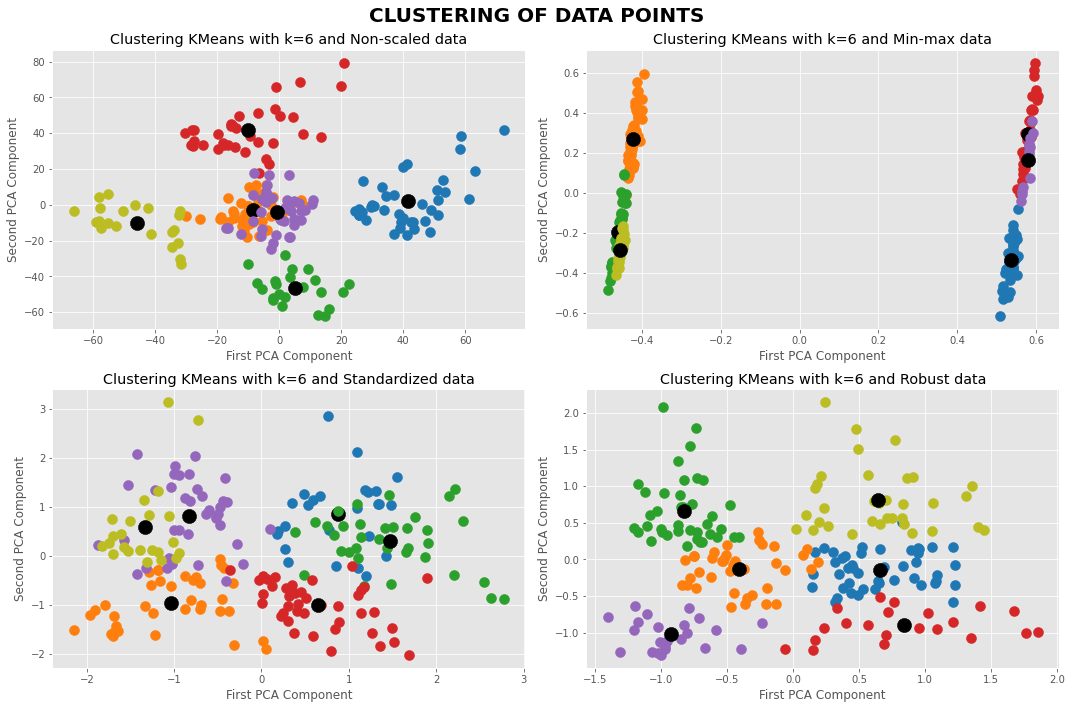

In [18]:
cluster_data_dict = find_clusters(data_enc, 6)
visualize_clustering(cluster_data_dict)

Now we are going to add the cluster assignation of all the customers as a column in our original dataframe. Recall that we obtained 4 the clusters through 4 types of data scaling (non-scaled, min-max, standardized and robust), thus we will add 4 columns.

In [31]:
df_copy = data.copy()

for data_name, clustered_dict in cluster_data_dict.items():
    col_name = str.lower(data_name.replace("data", "n_cluster").replace(" ", "_"))
    df_copy[col_name] = clustered_dict["cluster_assignation"]

cluster_cols = [col_name for col_name in df_copy.columns if "cluster" in col_name]

In [32]:
df_copy.head()

,Gender,Age,Annual Income,Spending Score,non-scaled_n_cluster,min-max_n_cluster,standardized_n_cluster,robust_n_cluster
0,Male,19,15,39,5,0,4,4
1,Male,21,15,81,2,0,4,4
2,Female,20,16,6,5,2,1,3
3,Female,23,16,77,2,2,1,4
4,Female,31,17,40,5,2,1,3


<Figure size 1800x432 with 0 Axes>

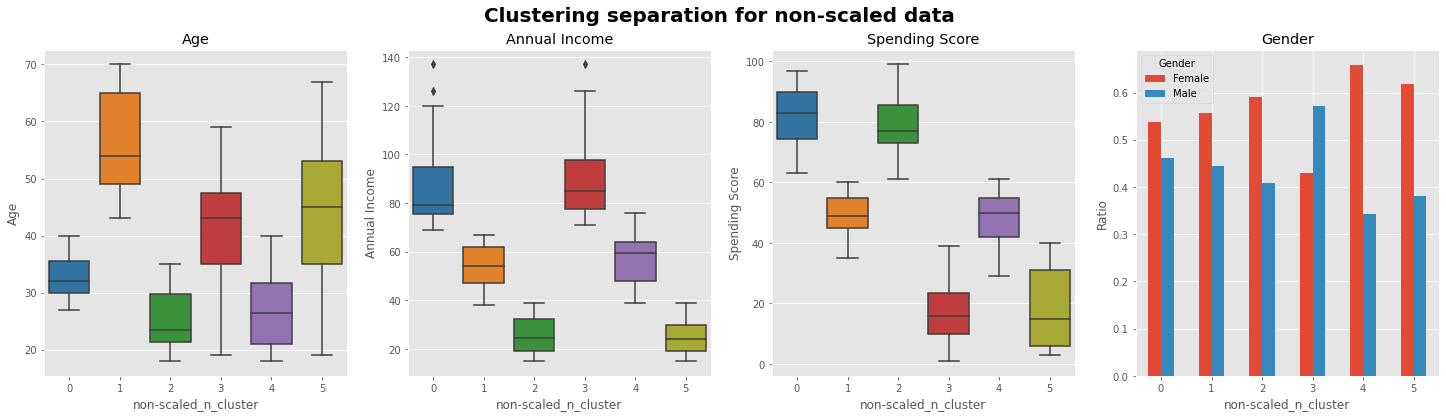

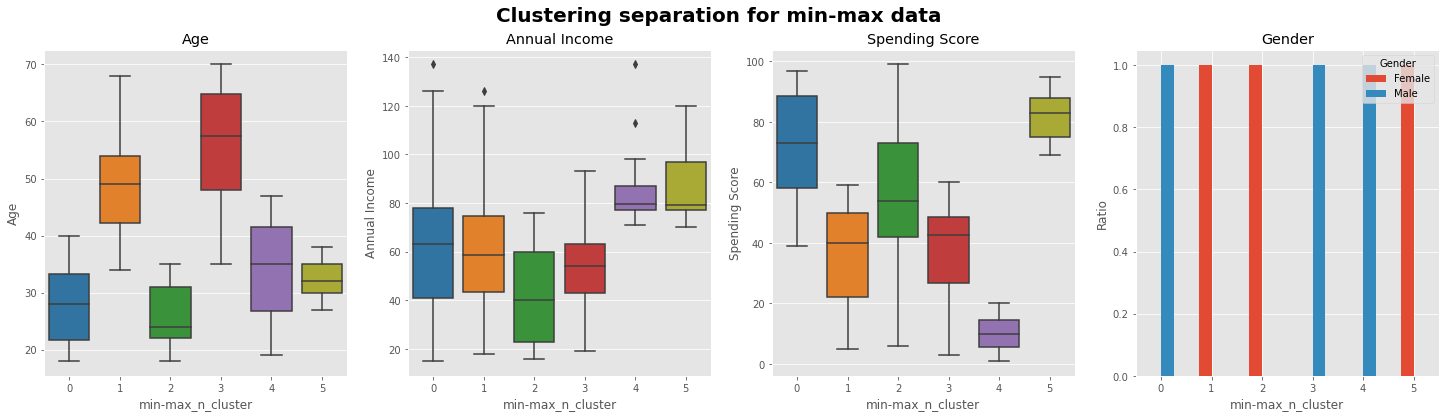

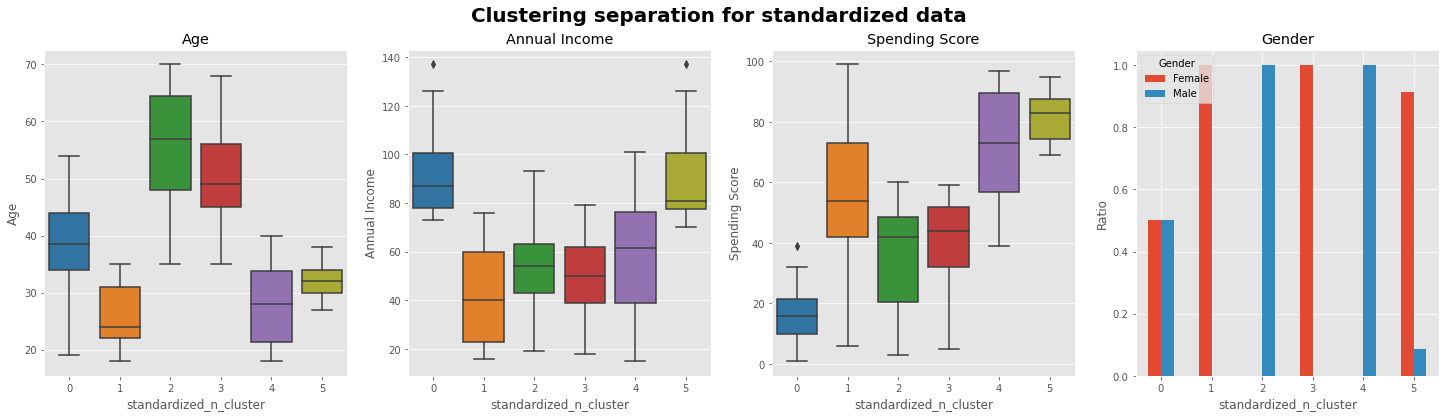

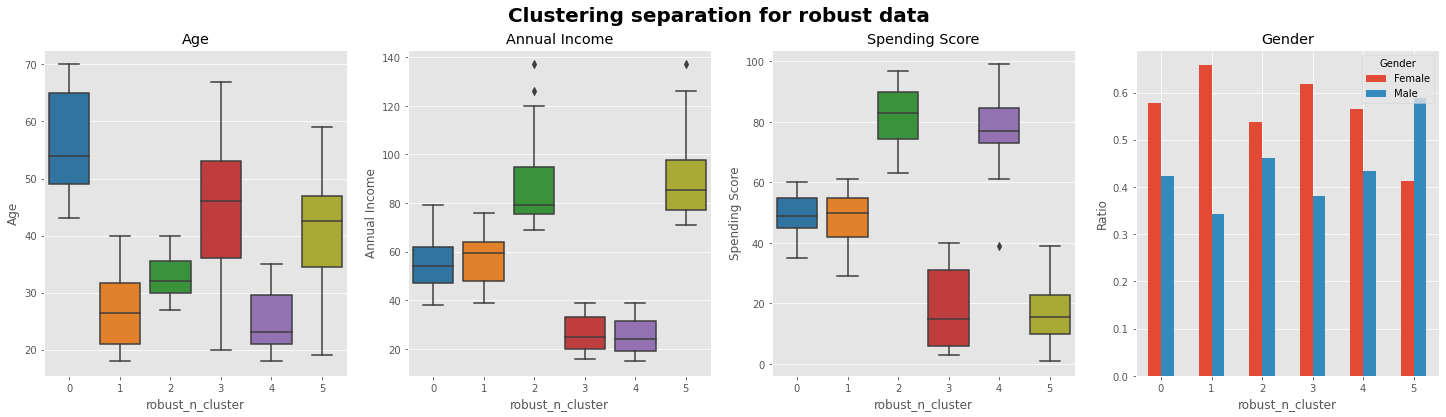

In [39]:
fig = plt.figure(figsize=(25,6))

palette = {0: "tab:blue", 1: "tab:orange", 2: "tab:green", 
           3: "tab:red", 4: "tab:purple", 5: "tab:olive",
           6: "tab:brown", 7: "tab:pink", 8: "tab:cyan"}

for type_scaling in cluster_cols:
    fig = plt.figure(figsize=(25,6))
    for i, col in enumerate(numerical_columns + ["Gender"]):
        sub = fig.add_subplot(1, len(numerical_columns)+1, i+1)
        if col == "Gender":
            norm_ct = pd.crosstab(df_copy["Gender"], df_copy[type_scaling])/pd.crosstab(df_copy["Gender"], df_copy[type_scaling]).sum()
            norm_ct.T.plot(kind="bar", ax=sub)
            sub.set_ylabel("Ratio")
            plt.xticks(rotation=0);
        else:
            sns.boxplot(data=df_copy, x=type_scaling, y=col, palette = palette, ax=sub)
        sub.set_title(col)
    fig.suptitle("Clustering separation for " + type_scaling.replace("_n_cluster","") + " data", fontsize=20, fontweight="bold")


By analyzing the above charts one can tell that the data scaling that results in better separation of clusters through K-Means is Standardization. Therefore, we will continue with our analysis using the standardized data.

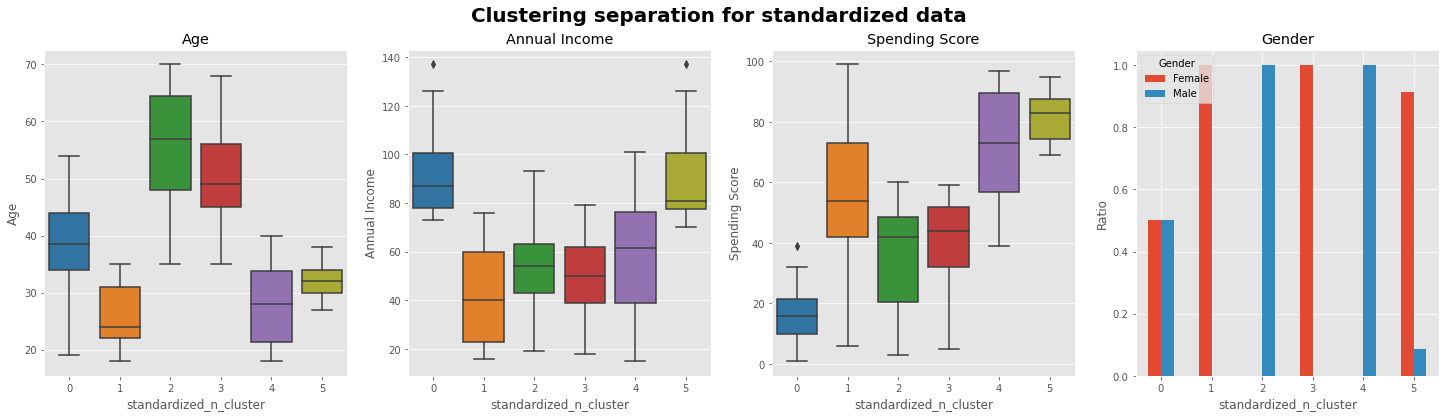

In [41]:
choosen_scale = "standardized_n_cluster"

fig = plt.figure(figsize=(25,6))
for i, col in enumerate(numerical_columns + ["Gender"]):
    sub = fig.add_subplot(1, len(numerical_columns)+1, i+1)
    if col == "Gender":
        norm_ct = pd.crosstab(df_copy["Gender"], df_copy[choosen_scale])/pd.crosstab(df_copy["Gender"], df_copy[choosen_scale]).sum()
        norm_ct.T.plot(kind="bar", ax=sub)
        sub.set_ylabel("Ratio")
        plt.xticks(rotation=0);
    else:
        sns.boxplot(data=df_copy, x=choosen_scale, y=col, palette = palette, ax=sub)
    sub.set_title(col)
fig.suptitle("Clustering separation for " + choosen_scale.replace("_n_cluster","") + " data", fontsize=20, fontweight="bold");

In [ ]:
cluster_cols.remove(choosen_scale)
data_f = df_copy.drop(cluster_cols, axis=1)
data_f.head()

In [60]:
c_ = data_f[data_f["standardized_n_cluster"] == 5]
c_.describe()

,Age,Annual Income,Spending Score,standardized_n_cluster
count,23.000000,23.000000,23.000000,23.0
mean,32.086957,90.000000,81.391304,5.0
std,2.968211,18.880004,7.644006,0.0
min,27.000000,70.000000,69.000000,5.0
25%,30.000000,77.500000,74.500000,5.0
50%,32.000000,81.000000,83.000000,5.0
75%,34.000000,100.500000,87.500000,5.0
max,38.000000,137.000000,95.000000,5.0


In [69]:
data_f.groupby(choosen_scale).size()

standardized_n_cluster
0    26
1    37
2    35
3    41
4    38
5    23
dtype: int64

From the previous chart we can characterize the 6 clusters based on the features:

**1. Cluster 0:** Customers under 54 years old, with an annual income higher than 73K USD and with a spending score below 39.

**2. Cluster 1:** Women under 35 years old, with an annual income between 16K USD and 76K USD.

**3. Cluster 2:** Men over 35 years old, with an annual income less than 93K USD and with a spending score below 60.

**4. Cluster 3:** Women over 35 years old, with an annual income less than 79K USD and with a spending score below 60.

**5. Cluster 4:** Men under 35 years old, with an annual income less than 100K USD and with an spending score above 40. 

**6. Cluster 5:** Mostly women between 27 and 38 years old, with an annual income above 70K USD and a spending score above 69.


Let's have some fun with visualization. We are going to plot our data points colored according to their cluster, on a 3D-plane with an interactive tool. We will have three axis in our plot: `Age`, `Annual Income` and `Spending Score`. The marker shape will account for `Gender`, with a diamond-shaped marker for `Male` and a circle for `Female`.

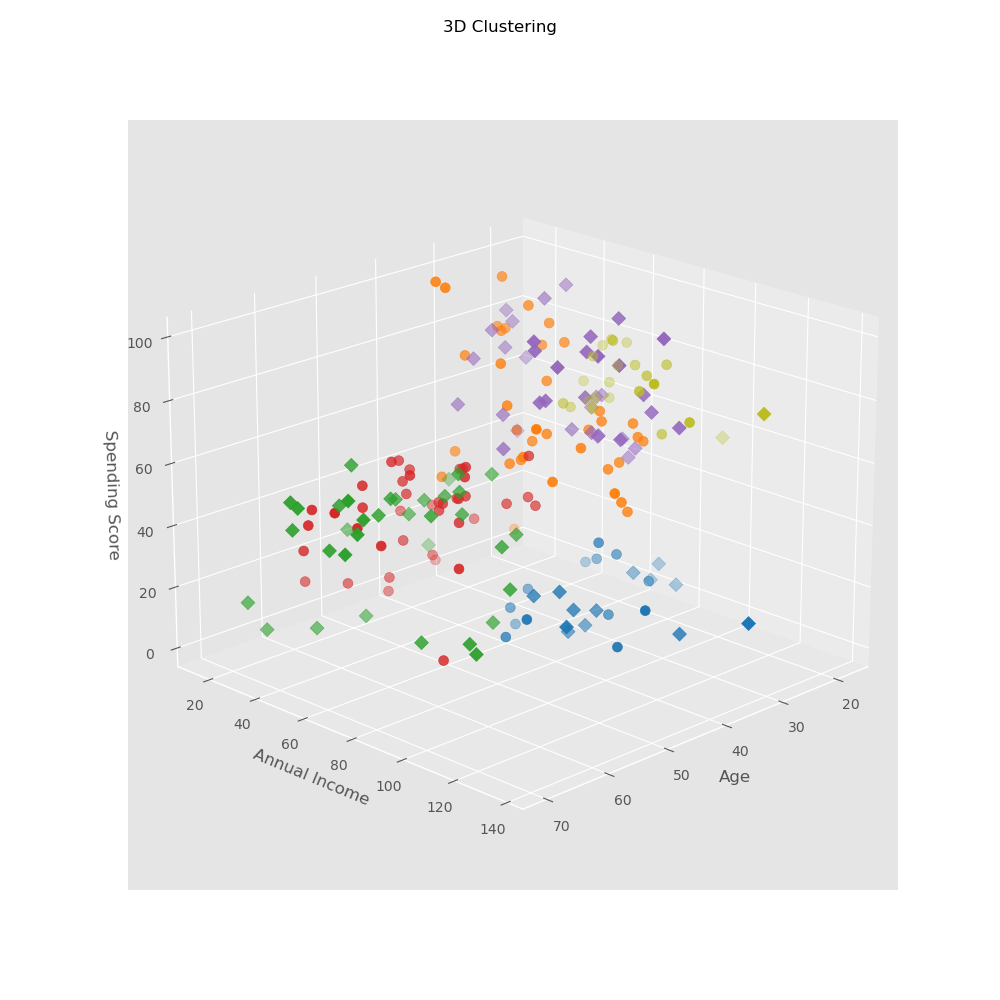

In [68]:
%matplotlib widget

colors = ["tab:blue", "tab:orange", "tab:green", 
        "tab:red", "tab:purple", "tab:olive",
        "tab:brown", "tab:pink", "tab:cyan"] 

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")

markers = {"Male": "D",
           "Female": "o"}

for gender in data_f["Gender"].unique():
        data_g = data_f[data["Gender"] == gender]
        for cluster_id in np.sort(data_g[choosen_scale].unique()):
                data_cluster = data_g[data_g[choosen_scale] == cluster_id]
                ax.scatter(data_cluster["Age"], 
                        data_cluster["Annual Income"], 
                        data_cluster["Spending Score"], 
                        color=colors[cluster_id], s=50, marker=markers[gender])
                   
ax.view_init(20, 45)

plt.xlabel("Age")
plt.ylabel("Annual Income")
ax.set_zlabel("Spending Score")
fig.suptitle("3D Clustering")
plt.show()

## 6. Conclusions

1. Customer segmentation is a very important tool when it comes to correctly aim marketing campaigns.
2. Scaling the data before implementing a clustering algorithm like K-Means is a must.
3. Separability of clusters across features is the most important aspect to evaluate when implementing a clustering strategy as it improves interpretability of the clusters.